# 確率勾配法を用いた2層ネットワークの実装

2次元データの2クラス分類問題を解く2層ネットワークを実装する．
ここではサンプルを1つづつ用いる確率勾配法を実装する．

# 準備

In [1]:
# load modules

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline
# plt.gray();
plt.set_cmap(plt.cm.Paired);

import sklearn
from sklearn.datasets import make_blobs

from ipywidgets import interact, interactive, fixed, RadioButtons
import ipywidgets as widgets
from IPython.display import display

!pip install autograd
import autograd.numpy as anp # autogradのnumpyの別名をanpにする
from autograd import grad
from autograd import jacobian, hessian

<Figure size 432x288 with 0 Axes>

In [2]:
# check versions

print("sklearn version :", sklearn.__version__, " >= 0.18.0")
# print("skimage version :", skimage.__version__, " >= 0.12.0")
print("numpy version :", np.__version__, " >= 0.12.0")
print("matplotlib version:", matplotlib.__version__, ">= 2.0.0")

sklearn version : 0.22.1  >= 0.18.0
numpy version : 1.18.1  >= 0.12.0
matplotlib version: 3.1.3 >= 2.0.0


# データセットの準備

sklearnのmake_blobで2次元データを準備する．
返り値は，データXとラベルyである．ただし2クラスの場合，ラベルyは0,1で返ってくるため，-1と+1に変更しておく．

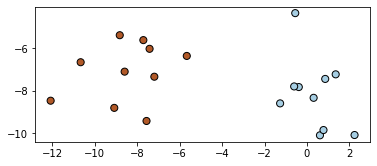

In [3]:
X, y = make_blobs(n_samples=20, # 20個生成
                  n_features=2, # 2次元
                  centers=2,    # クラスタ中心2個
                  cluster_std = 2 # クラスタの大きさ（標準偏差）
                 )
y = (2*y - 1).astype(float) # 0,1 -> -1.0,+1.0

X = np.hstack((X, np.ones((X.shape[0], 1)))) # 同次座標

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, edgecolors='k');
plt.gca().set_aspect('equal');

識別境界を直線で描くヘルパー関数の準備．

In [4]:
# 境界線を引く関数の定義

def plotBoundary(X, net, w, mesh=True, boundary=True, n_neighbors=1):

    # plot range
    x_min = min(X[:,0])
    x_max = max(X[:,0])
    y_min = min(X[:,1])
    y_max = max(X[:,1])

    # visualizing decision function
    XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j] # make a grid
    Z = np.zeros(XX.size)
    for i,xi in enumerate(np.c_[XX.ravel(), YY.ravel(), np.ones(XX.size)]):
        Z[i] = net(w, xi)

    
    Z = Z.reshape(XX.shape) # just reshape
    Z = np.sign(Z) # -1 or +1

    if mesh:
        plt.pcolormesh(XX, YY, Z, zorder=-10) # paint in 2 colors, if Z > 0 or not

    if boundary:
        if Z.min() < 0.5 < Z.max():
            plt.contour(XX, YY, Z, alpha=0.5,
                        colors='k', linestyles='-', levels=[0])

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

# 2層ネットワークの実装

以下は，1層ネットワークとして，ヒンジ損失を用いるパーセプトロンと，ロジスティック損失を用いるロジスティック回帰の実装例である．

In [5]:
# 1層ネットワーク
w = np.random.rand(3) - 0.5 # 次元＋1：同次座標

def mynet(w, xi):
    return anp.dot(xi, w)

def loss(w, xi, yi):
    h = yi * mynet(w, xi)
#     return anp.maximum(-h, 0) # ヒンジ損失（パーセプトロン）
    return anp.log(1 + anp.exp(-h)) # ロジスティック損失

g_mynet = grad(loss) # wについての勾配

以下の2層ネットワークは，活性化関数をReLUやsigmoidなどにした例である． 第1層では入力の3次元を線形変換で6次元の中間層にして活性化関数を適用する．その後に，第2層では6次元を1次元にする．

In [6]:
# 2層ネットワーク
w1 = anp.random.rand(3,6).flatten() - 0.5
w2 = anp.random.rand(6,1).flatten() - 0.5
w = np.concatenate((w1, w2))

def sig(a):
    return 1 / (1 + anp.exp(-a))
def ReLU(a):
    return anp.maximum(a, 0)

def mynet(w, xi):
    return anp.dot(ReLU(anp.dot(xi, w[:18].reshape(3,6))), w[18:].reshape(6,1))

def loss(w, xi, yi):
    h = yi * mynet(w, xi)
    return anp.log(1 + anp.exp(-h)) # ロジスティック損失

g_mynet = grad(loss) # wについての勾配

ネットワークの出力と勾配の出力を確かめる（デバッグ）．

In [7]:
xi = X[0]
yi = y[0]
print(mynet(w, xi))
print(g_mynet(w, xi, yi))

[0.18651072]
[ 0.          0.         -0.01358295  0.          0.          0.09758247
  0.          0.          0.22366821  0.          0.         -1.60687482
  0.          0.         -0.02213473  0.          0.          0.1590201
  0.          0.          0.11652601  0.          0.          0.36650431]


以下では，サンプルを先頭から順番に一つずつ用いて，SGDの更新則を適用する．
サンプルは青と茶色のクラスに分かれている．識別境界を引いた後に，同じ色の領域に入っていれば正答，違う色の領域に入ってしまっていれば誤答である．

In [8]:
val_start = 0 # スライドバーの最小値
val_end   = len(y)-1 # スライドバーの最大値
val_step  = 1 # スライドバーはこの値ずつ増える
val_default = 0 # スライドバーの初期値


@interact(sample=(val_start, val_end, val_step)) # この行が関数の直前に必要
def g(sample=val_default): # この関数を毎回呼び出す    
    
    global w
    
    if sample > len(y)-1:
        return

    plt.scatter(X[:, 0], X[:, 1], marker='o', s=50, c=y, edgecolors='k')
    plt.scatter(X[sample, 0], X[sample, 1], marker='o', s=90, facecolors='none',  edgecolors='k')
   
    plotBoundary(X, mynet, w)
    
    xi = X[sample]
    yi = y[sample]

   
    plt.gca().set_aspect('equal');
    plt.show()

    # 更新則
    alpha = 0.01
    w = w - alpha * g_mynet(w, xi, yi)

    

interactive(children=(IntSlider(value=0, description='sample', max=19), Output()), _dom_classes=('widget-inter…

# Task

- 上記の2層ネットワークを改変して，3層ネットワークを実装せよ．
- 中間層の次元を変えて，収束を議論せよ．

# 損失関数の可視化と学習率の変更

In [9]:
val_start = 0 # スライドバーの最小値
val_end   = len(y)-1 # スライドバーの最大値
val_step  = 1 # スライドバーはこの値ずつ増える
val_default = 0 # スライドバーの初期値

loss_val = []

@interact(sample=(val_start, val_end, val_step), alpha=[1.0, 0.1, 0.01, 0.001]) # この行が関数の直前に必要
def g(sample=val_default, alpha=0.01): # この関数を毎回呼び出す    
  
    global w
    
    if sample > len(y)-1:
        return

    plt.scatter(X[:, 0], X[:, 1], marker='o', s=50, c=y, edgecolors='k')
    plt.scatter(X[sample, 0], X[sample, 1], marker='o', s=90, facecolors='none',  edgecolors='k')
   
    plotBoundary(X, mynet, w)
    
    xi = X[sample]
    yi = y[sample]

   
    plt.gca().set_aspect('equal');
    plt.show()

    loss_val.append(sum([loss(w, xi, yi) for xi,yi in zip(X,y)])) # loss for all samples
    plt.plot(loss_val)
    plt.ylabel('loss')
    plt.xlabel('iterations')
    plt.show()

    # 更新則
    w = w - alpha * g_mynet(w, xi, yi)

    

interactive(children=(IntSlider(value=0, description='sample', max=19), Dropdown(description='alpha', index=2,…